### Notes: 

Pushpendra notebook already has data exploration for TPS data



TO DO:
leverage TPS GeoService or GeoJSON:
https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/MCI_2014_to_2019/FeatureServer/0/query?outFields=*&where=1%3D1

ckan api for city of toronto:
https://ckan0.cf.opendata.inter.prod-toronto.ca/organization/city-of-toronto

In [87]:
#import the necessay modules
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import cm
import re
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
#from pdpbox import pdp, get_dataset, info_plots

ModuleNotFoundError: No module named 'lightgbm'

# 1. Load Data

In [138]:
# load Toronto Police Service data
import pandas as pd
import io
import requests

url = "https://opendata.arcgis.com/datasets/56a0d46ae5f141269f2598a8c07e25c1_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D"
s=requests.get(url).content
df_tps=pd.read_csv(io.StringIO(s.decode('utf-8')))

df_tps.head()

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,...,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,ObjectId
0,-8.840549e+06,5.431712e+06,201,GO-20141301077,2014/01/07 05:00:00+00,2014/01/07 05:00:00+00,Other,1420,100,Assault With Weapon,...,7.0,Tuesday,22,Assault,D32,36,Newtonbrook West (36),43.781639,-79.416,1
1,-8.840549e+06,5.431712e+06,202,GO-20141301077,2014/01/07 05:00:00+00,2014/01/07 05:00:00+00,Other,1420,100,Assault With Weapon,...,7.0,Tuesday,22,Assault,D32,36,Newtonbrook West (36),43.781639,-79.416,2
2,-8.840549e+06,5.431712e+06,203,GO-20141301077,2014/01/07 05:00:00+00,2014/01/07 05:00:00+00,Other,1420,100,Assault With Weapon,...,7.0,Tuesday,22,Assault,D32,36,Newtonbrook West (36),43.781639,-79.416,3
3,-8.840549e+06,5.431712e+06,204,GO-20141301077,2014/01/07 05:00:00+00,2014/01/07 05:00:00+00,Other,1420,100,Assault With Weapon,...,7.0,Tuesday,22,Assault,D32,36,Newtonbrook West (36),43.781639,-79.416,4
4,-8.839881e+06,5.413806e+06,205,GO-20141300854,2014/01/07 05:00:00+00,2014/01/07 05:00:00+00,Commercial,2120,200,B&E,...,7.0,Tuesday,21,Break and Enter,D14,79,University (79),43.665390,-79.410,5


In [139]:
df_tps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206435 entries, 0 to 206434
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   X                    206435 non-null  float64
 1   Y                    206435 non-null  float64
 2   Index_               206435 non-null  int64  
 3   event_unique_id      206435 non-null  object 
 4   occurrencedate       206435 non-null  object 
 5   reporteddate         206435 non-null  object 
 6   premisetype          206435 non-null  object 
 7   ucr_code             206435 non-null  int64  
 8   ucr_ext              206435 non-null  int64  
 9   offence              206435 non-null  object 
 10  reportedyear         206435 non-null  int64  
 11  reportedmonth        206435 non-null  object 
 12  reportedday          206435 non-null  int64  
 13  reporteddayofyear    206435 non-null  int64  
 14  reporteddayofweek    206435 non-null  object 
 15  reportedhour     

In [140]:
df_tps.describe()

,X,Y,Index_,ucr_code,ucr_ext,reportedyear,reportedday,reporteddayofyear,reportedhour,occurrenceyear,occurrenceday,occurrencedayofyear,occurrencehour,Hood_ID,Lat,Long,ObjectId
count,2.064350e+05,2.064350e+05,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206376.000000,206376.000000,206376.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000
mean,-8.838204e+06,5.420273e+06,103218.000000,1696.667755,145.973953,2016.619323,15.746855,187.139933,12.838617,2016.579171,15.511024,186.506653,12.549868,72.230286,43.707379,-79.394939,103218.000000
std,1.161962e+04,8.119214e+03,59592.795747,323.481988,51.739660,1.717764,8.770511,103.601412,6.583508,1.764401,8.904154,103.884073,7.220263,40.758981,0.052718,0.104381,59592.795747
min,-8.865373e+06,5.401765e+06,1.000000,1410.000000,100.000000,2014.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.000000,0.000000,1.000000,43.587093,-79.639000,1.000000
25%,-8.846671e+06,5.413154e+06,51609.500000,1430.000000,100.000000,2015.000000,8.000000,100.000000,8.000000,2015.000000,8.000000,99.000000,7.000000,36.000000,43.661152,-79.471000,51609.500000
50%,-8.837988e+06,5.419338e+06,103218.000000,1450.000000,100.000000,2017.000000,16.000000,189.000000,14.000000,2017.000000,16.000000,188.000000,14.000000,76.000000,43.701328,-79.393000,103218.000000
75%,-8.829751e+06,5.427154e+06,154826.500000,2120.000000,200.000000,2018.000000,23.000000,277.000000,18.000000,2018.000000,23.000000,276.000000,19.000000,108.000000,43.752068,-79.319000,154826.500000
max,-8.807932e+06,5.442380e+06,206435.000000,2135.000000,230.000000,2019.000000,31.000000,366.000000,23.000000,2019.000000,31.000000,366.000000,23.000000,140.000000,43.850788,-79.123000,206435.000000


In [141]:
df_tps.isnull().sum()

X                       0
Y                       0
Index_                  0
event_unique_id         0
occurrencedate          0
reporteddate            0
premisetype             0
ucr_code                0
ucr_ext                 0
offence                 0
reportedyear            0
reportedmonth           0
reportedday             0
reporteddayofyear       0
reporteddayofweek       0
reportedhour            0
occurrenceyear         59
occurrencemonth        59
occurrenceday          59
occurrencedayofyear    59
occurrencedayofweek    59
occurrencehour          0
MCI                     0
Division                0
Hood_ID                 0
Neighbourhood           0
Lat                     0
Long                    0
ObjectId                0
dtype: int64

In [157]:
# loading this second set of data from TPS as its organized by neighbourhood and includes:
#   population as of 2016 census
#   homicide (for some reason not included on other dataset)

url = "https://opendata.arcgis.com/datasets/af500b5abb7240399853b35a2362d0c0_0.csv?outSR=%7B%22latestWkid%22%3A26717%2C%22wkid%22%3A26717%7D"
s=requests.get(url).content
df_tps_hood=pd.read_csv(io.StringIO(s.decode('utf-8')))

df_tps_hood.head()
    

,OBJECTID,Neighbourhood,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,...,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length
0,1,Yonge-St.Clair,97,12528,20,29,39,27,34,37,...,5,8,0,3,6,4.3,1.00,47.9,1.161315e+06,5873.270582
1,2,York University Heights,27,27593,271,296,361,344,357,370,...,46,37,39,38,28,36.3,-0.26,101.5,1.324666e+07,18504.777326
2,3,Lansing-Westgate,38,16164,44,80,68,85,75,72,...,5,5,11,6,11,7.0,0.83,68.1,5.346186e+06,11112.109625
3,4,Yorkdale-Glen Park,31,14804,106,136,174,161,175,209,...,14,26,23,20,29,22.5,0.45,195.9,6.038326e+06,10079.426920
4,5,Stonegate-Queensway,16,25051,88,71,76,95,87,82,...,8,4,6,7,4,6.0,-0.43,16.0,7.946202e+06,11853.189878


In [158]:
df_tps_hood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   OBJECTID                 140 non-null    int64  
 1   Neighbourhood            140 non-null    object 
 2   Hood_ID                  140 non-null    int64  
 3   Population               140 non-null    int64  
 4   Assault_2014             140 non-null    int64  
 5   Assault_2015             140 non-null    int64  
 6   Assault_2016             140 non-null    int64  
 7   Assault_2017             140 non-null    int64  
 8   Assault_2018             140 non-null    int64  
 9   Assault_2019             140 non-null    int64  
 10  Assault_AVG              140 non-null    float64
 11  Assault_CHG              140 non-null    float64
 12  Assault_Rate_2019        140 non-null    float64
 13  AutoTheft_2014           140 non-null    int64  
 14  AutoTheft_2015           1

In [159]:
df_tps_hood.describe()

,OBJECTID,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_AVG,...,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length
count,140.0000,140.0000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,...,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,1.400000e+02,140.000000
mean,70.5000,70.5000,19511.221429,117.350000,126.885714,132.200000,134.607143,138.935714,145.900000,132.646429,...,7.328571,7.321429,8.314286,8.764286,9.678571,8.082857,0.377643,47.132143,4.589400e+06,10138.063215
std,40.5586,40.5586,10033.589222,106.968961,119.613531,126.501014,137.168053,142.883824,148.500529,128.977375,...,9.228859,9.023764,9.708771,10.936449,11.918348,9.427947,0.925275,41.478434,4.665326e+06,5545.517459
min,1.0000,1.0000,6577.000000,16.000000,12.000000,10.000000,20.000000,15.000000,17.000000,18.500000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.200000,-1.000000,0.000000,4.241968e+05,2574.408515
25%,35.7500,35.7500,12019.500000,53.750000,57.250000,57.500000,58.750000,58.750000,62.000000,59.425000,...,3.000000,2.000000,3.000000,3.000000,3.000000,3.500000,-0.200000,22.750000,1.861853e+06,6372.358386
50%,70.5000,70.5000,16749.500000,85.000000,92.000000,97.000000,94.000000,93.500000,99.500000,96.500000,...,5.000000,4.500000,5.000000,5.000000,6.000000,5.200000,0.110000,37.400000,3.290879e+06,8962.102935
75%,105.2500,105.2500,23854.500000,141.250000,152.250000,166.250000,159.500000,167.500000,172.000000,160.200000,...,8.000000,8.000000,10.000000,10.000000,10.250000,8.350000,0.670000,54.650000,5.402335e+06,11899.512705
max,140.0000,140.0000,65913.000000,738.000000,826.000000,888.000000,905.000000,910.000000,916.000000,851.800000,...,58.000000,59.000000,58.000000,59.000000,73.000000,56.200000,4.000000,283.000000,3.753449e+07,43080.724701


In [160]:
df_tps_hood.isnull().sum()

OBJECTID                   0
Neighbourhood              0
Hood_ID                    0
Population                 0
Assault_2014               0
Assault_2015               0
Assault_2016               0
Assault_2017               0
Assault_2018               0
Assault_2019               0
Assault_AVG                0
Assault_CHG                0
Assault_Rate_2019          0
AutoTheft_2014             0
AutoTheft_2015             0
AutoTheft_2016             0
AutoTheft_2017             0
AutoTheft_2018             0
AutoTheft_2019             0
AutoTheft_AVG              0
AutoTheft_CHG              0
AutoTheft_Rate_2019        0
BreakandEnter_2014         0
BreakandEnter_2015         0
BreakandEnter_2016         0
BreakandEnter_2017         0
BreakandEnter_2018         0
BreakandEnter_2019         0
BreakandEnter_AVG          0
BreakandEnter_CHG          0
BreakandEnter_Rate_2019    0
Homicide_2014              0
Homicide_2015              0
Homicide_2016              0
Homicide_2017 

In [23]:
# load Toronto Open Data

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = urlopen('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/fa139bae-8e6b-4e0c-8b36-53161970f89e')
myzip = ZipFile(BytesIO(url.read())).extract('Registered_Programs_and_Drop_In_Courses_Offering.xlsx')
df_programs = pd.read_excel(myzip, sheet_name=0)
df_dropin = pd.read_excel(myzip,sheet_name=1)
df_locations = pd.read_excel(myzip, sheet_name=2)
df_facilities = pd.read_excel(myzip,sheet_name=3)

df_locations.head()

,Location ID,Parent Location ID,Location Name,Location Type,Accessibility,Intersection,TTC Information,District,Street No,Street No Suffix,Street Name,Street Type,Street Direction,Postal Code,Description
0,1,1,Ashbridges Bay Park,park,NaN,NaN,Travel to Woodbine Station. Board the 92 Wood...,Waterfront,1561,NaN,LAKE SHORE,BLVD,E,NaN,Ashbridges Bay Park is located in a beautiful ...
1,2,2,Bluffer's Park and Beach,park,NaN,NaN,Check TTC schedule or use TTC Trip Planner for...,Scarborough,1,NaN,BRIMLEY,RD,S,NaN,Bluffer's Park was designed to improve public ...
2,3,3,James Gardens,park,NaN,Edgehill Road and Edenbridge Drive,TTC accessible from Royal York station. Take ...,Etobicoke York,99,NaN,Edenbridge,Dr.,NaN,NaN,"James Gardens, a former estate on the west ban..."
3,4,4,Colonel Danforth Park,park,NaN,Colonel Danforth Trail & Bonacres Ave,Take the 86 Scarborough Bus to Military Trail ...,Scarborough,73,NaN,COLONEL DANFORTH,TRL,NaN,NaN,Colonel Danforth Park can be found northwest o...
4,5,5,Derrydowns Park,park,NaN,Derrydown Rd & Conamore Cres,NaN,North York,271,NaN,DERRYDOWN,RD,NaN,NaN,Derrydowns Park is a 28 hectare park following...


In [142]:
df_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Location ID         1941 non-null   int64 
 1   Parent Location ID  1941 non-null   int64 
 2   Location Name       1941 non-null   object
 3   Location Type       1941 non-null   object
 4   Accessibility       1941 non-null   object
 5   Intersection        1941 non-null   object
 6   TTC Information     1941 non-null   object
 7   District            1941 non-null   object
 8   Street No           1941 non-null   object
 9   Street No Suffix    1941 non-null   object
 10  Street Name         1941 non-null   object
 11  Street Type         1941 non-null   object
 12  Street Direction    1941 non-null   object
 13  Postal Code         1941 non-null   object
 14  Description         1941 non-null   object
 15  Address             1941 non-null   object
 16  ADDRESS             1941

In [143]:
df_locations.describe()

,Location ID,Parent Location ID
count,1941.000000,1941.000000
mean,1404.391036,1374.673364
std,987.563033,990.326425
min,1.000000,1.000000
25%,565.000000,530.000000
50%,1110.000000,1094.000000
75%,2290.000000,2273.000000
max,3702.000000,4757.000000


In [144]:
df_locations.isnull().sum()

Location ID           0
Parent Location ID    0
Location Name         0
Location Type         0
Accessibility         0
Intersection          0
TTC Information       0
District              0
Street No             0
Street No Suffix      0
Street Name           0
Street Type           0
Street Direction      0
Postal Code           0
Description           0
Address               0
ADDRESS               0
dtype: int64

In [24]:
# load mapping of TPS to Toronto Open Data

url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRLItUA-N12_u7ug3OSrdf4QTHV3qavd4YAABgk6DqXsUqwvH_8C3YKuC_d9nSI1A/pub?output=csv"
t=requests.get(url).content
df_mapping=pd.read_csv(io.StringIO(t.decode('utf-8')))

df_mapping.head()

,responsible,Location Name,Location ID,Parent Location ID,Ward,Neighbourhood,Hood_ID
0,sd,Adam Beck Community Centre,13,13,19,East End-Danforth,62
1,sd,Agincourt Recreation Centre,523,523,41,Agincourt South-Malvern West,128
2,sd,Albion Arena,800,800,1,Mount Olive-Silverstone-Jamestown,2
3,sd,Albion Pool and Health Club,893,893,1,Mount Olive-Silverstone-Jamestown,2
4,sd,Amesbury Community Centre,472,472,12,Brookhaven-Amesbury,30


In [269]:
df_mapping.isnull().sum()

responsible           0
Location Name         0
Location ID           0
Parent Location ID    0
Ward                  0
Neighbourhood         0
Hood_ID               0
dtype: int64

In [272]:
# better would be to check with neighbourhoods do NOT have any rec centres
# turns out there are 40 out of 140 neighbourhoods do NOT have any rec centres - that is high proportion

crc = df_mapping[['Location Name','Hood_ID']].groupby('Hood_ID').count().reset_index()
crc

,Hood_ID,Location Name
0,2,5
1,3,2
2,4,1
3,5,2
4,6,1
...,...,...
95,134,1
96,135,2
97,136,1
98,137,2


In [264]:
df_mapping.describe()

,Location ID,Parent Location ID,Ward,Hood_ID
count,166.000000,166.000000,166.000000,166.000000
mean,754.042169,688.777108,13.012048,62.813253
std,651.689435,587.841500,9.897651,43.345351
min,7.000000,3.000000,1.000000,2.000000
25%,399.000000,351.750000,5.000000,24.250000
50%,642.500000,567.500000,12.000000,57.000000
75%,891.750000,816.500000,19.000000,104.500000
max,3643.000000,3643.000000,43.000000,139.000000


# 2. Data Analysis

In [161]:
# of crimes per Hood ID - concentrate on 2019 
df_tps_hood

,OBJECTID,Neighbourhood,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,...,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length
0,1,Yonge-St.Clair,97,12528,20,29,39,27,34,37,...,5,8,0,3,6,4.3,1.00,47.9,1.161315e+06,5873.270582
1,2,York University Heights,27,27593,271,296,361,344,357,370,...,46,37,39,38,28,36.3,-0.26,101.5,1.324666e+07,18504.777326
2,3,Lansing-Westgate,38,16164,44,80,68,85,75,72,...,5,5,11,6,11,7.0,0.83,68.1,5.346186e+06,11112.109625
3,4,Yorkdale-Glen Park,31,14804,106,136,174,161,175,209,...,14,26,23,20,29,22.5,0.45,195.9,6.038326e+06,10079.426920
4,5,Stonegate-Queensway,16,25051,88,71,76,95,87,82,...,8,4,6,7,4,6.0,-0.43,16.0,7.946202e+06,11853.189878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,136,Milliken,130,26572,66,92,88,80,78,99,...,14,10,19,18,22,16.5,0.22,82.8,9.477859e+06,16781.477343
136,137,Pleasant View,46,15818,34,50,58,53,37,44,...,5,3,4,5,4,3.8,-0.20,25.3,2.967493e+06,7944.829848
137,138,Wychwood,94,14349,54,76,86,55,76,74,...,1,4,4,2,0,2.3,-1.00,0.0,1.682111e+06,5435.021879
138,139,Leaside-Bennington,56,16828,38,27,33,35,33,31,...,5,2,4,4,7,5.2,0.75,41.6,4.784766e+06,14836.618578


In [191]:
cols = ['Neighbourhood', 'Population',
'Assault_2019',
 'AutoTheft_2019',
 'BreakandEnter_2019',
 'Homicide_2019',
 'Robbery_2019',
 'TheftOver_2019']

In [193]:
df_tps_hood[cols]

,Neighbourhood,Population,Assault_2019,AutoTheft_2019,BreakandEnter_2019,Homicide_2019,Robbery_2019,TheftOver_2019
0,Yonge-St.Clair,12528,37,6,28,0,4,6
1,York University Heights,27593,370,144,108,0,79,28
2,Lansing-Westgate,16164,72,32,39,0,11,11
3,Yorkdale-Glen Park,14804,209,61,84,1,42,29
4,Stonegate-Queensway,25051,82,34,64,0,22,4
...,...,...,...,...,...,...,...,...
135,Milliken,26572,99,83,132,1,33,22
136,Pleasant View,15818,44,24,12,0,15,4
137,Wychwood,14349,74,7,47,1,9,0
138,Leaside-Bennington,16828,31,32,44,0,2,7


In [205]:
personal = "\'Assault_2019\',\'Homicide_2019\'"
property = ['AutoTheft_2019',
 'BreakandEnter_2019',
 'Robbery_2019',
 'TheftOver_2019']

In [218]:
df_tps_hood['personal_2019'] = df_tps_hood['Assault_2019'] + df_tps_hood['Homicide_2019']
df_tps_hood['property_2019'] = df_tps_hood['AutoTheft_2019'] + df_tps_hood['Homicide_2019'] + df_tps_hood['Robbery_2019'] + df_tps_hood['TheftOver_2019'] 

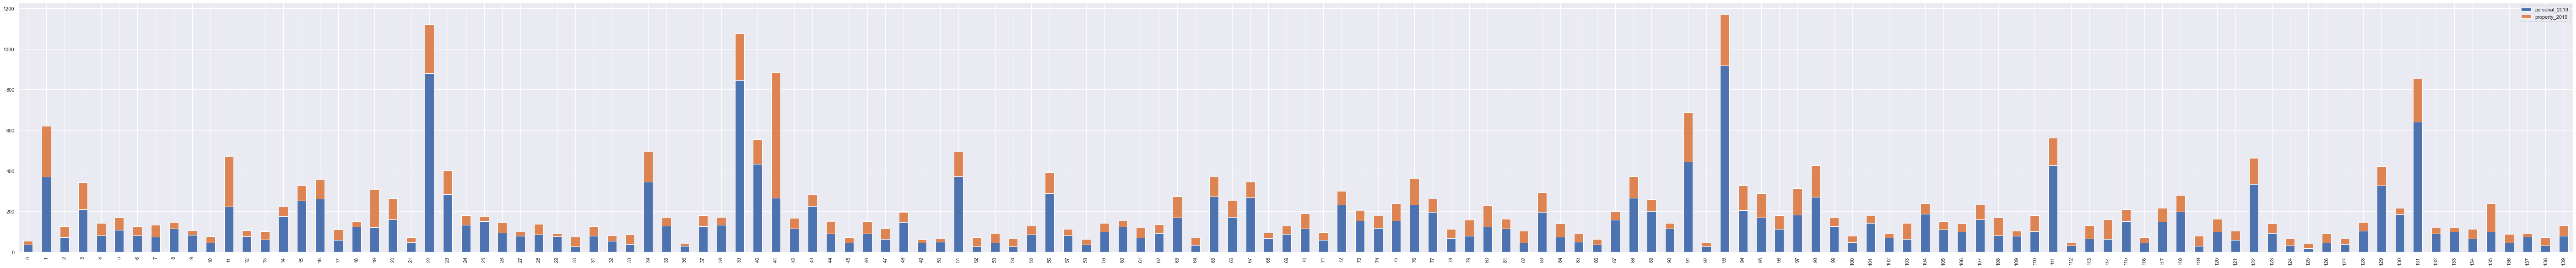

In [236]:
# plot
df_tps_hood[['Neighbourhood','personal_2019','property_2019']].plot.bar(stacked=True, figsize=(100,10))

# could do better graphs here...


In [242]:
# mean of personal is 146 and property is 71; population mean is 19511
# surpising how there is more personal crime vs property ... maybe we have 2 different independent variables

df_tps_hood.describe()

,OBJECTID,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_AVG,...,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length,personal_2019,property_2019
count,140.0000,140.0000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,...,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,1.400000e+02,140.000000,140.000000,140.000000
mean,70.5000,70.5000,19511.221429,117.350000,126.885714,132.200000,134.607143,138.935714,145.900000,132.646429,...,8.314286,8.764286,9.678571,8.082857,0.377643,47.132143,4.589400e+06,10138.063215,146.457143,71.685714
std,40.5586,40.5586,10033.589222,106.968961,119.613531,126.501014,137.168053,142.883824,148.500529,128.977375,...,9.708771,10.936449,11.918348,9.427947,0.925275,41.478434,4.665326e+06,5545.517459,148.871263,69.724131
min,1.0000,1.0000,6577.000000,16.000000,12.000000,10.000000,20.000000,15.000000,17.000000,18.500000,...,0.000000,0.000000,0.000000,1.200000,-1.000000,0.000000,4.241968e+05,2574.408515,17.000000,12.000000
25%,35.7500,35.7500,12019.500000,53.750000,57.250000,57.500000,58.750000,58.750000,62.000000,59.425000,...,3.000000,3.000000,3.000000,3.500000,-0.200000,22.750000,1.861853e+06,6372.358386,63.500000,35.750000
50%,70.5000,70.5000,16749.500000,85.000000,92.000000,97.000000,94.000000,93.500000,99.500000,96.500000,...,5.000000,5.000000,6.000000,5.200000,0.110000,37.400000,3.290879e+06,8962.102935,100.000000,49.500000
75%,105.2500,105.2500,23854.500000,141.250000,152.250000,166.250000,159.500000,167.500000,172.000000,160.200000,...,10.000000,10.000000,10.250000,8.350000,0.670000,54.650000,5.402335e+06,11899.512705,172.000000,81.500000
max,140.0000,140.0000,65913.000000,738.000000,826.000000,888.000000,905.000000,910.000000,916.000000,851.800000,...,58.000000,59.000000,73.000000,56.200000,4.000000,283.000000,3.753449e+07,43080.724701,919.000000,617.000000


In [245]:
# lets calculate per capita
# for smaller measurements, multiple by 10000
# for example 0.016 x 100000 = 1600 which translates to 1600 cases per every 100,000 in the population

df_tps_hood['capita_personal_2019'] = df_tps_hood['personal_2019'] / df_tps_hood['Population'] * 100000
df_tps_hood['capita_property_2019'] = df_tps_hood['property_2019'] / df_tps_hood['Population'] * 100000


In [258]:
df_tps_hood_graph = df_tps_hood[['Hood_ID','Neighbourhood','capita_personal_2019','capita_property_2019']]
df_tps_hood_graph

,Hood_ID,Neighbourhood,capita_personal_2019,capita_property_2019
0,97,Yonge-St.Clair,295.338442,127.713921
1,27,York University Heights,1340.919798,909.650998
2,38,Lansing-Westgate,445.434298,334.075724
3,31,Yorkdale-Glen Park,1418.535531,898.405836
4,16,Stonegate-Queensway,327.332242,239.511397
...,...,...,...,...
135,130,Milliken,376.335993,523.107030
136,46,Pleasant View,278.164117,271.842205
137,94,Wychwood,522.684508,118.475155
138,56,Leaside-Bennington,184.216782,243.641550


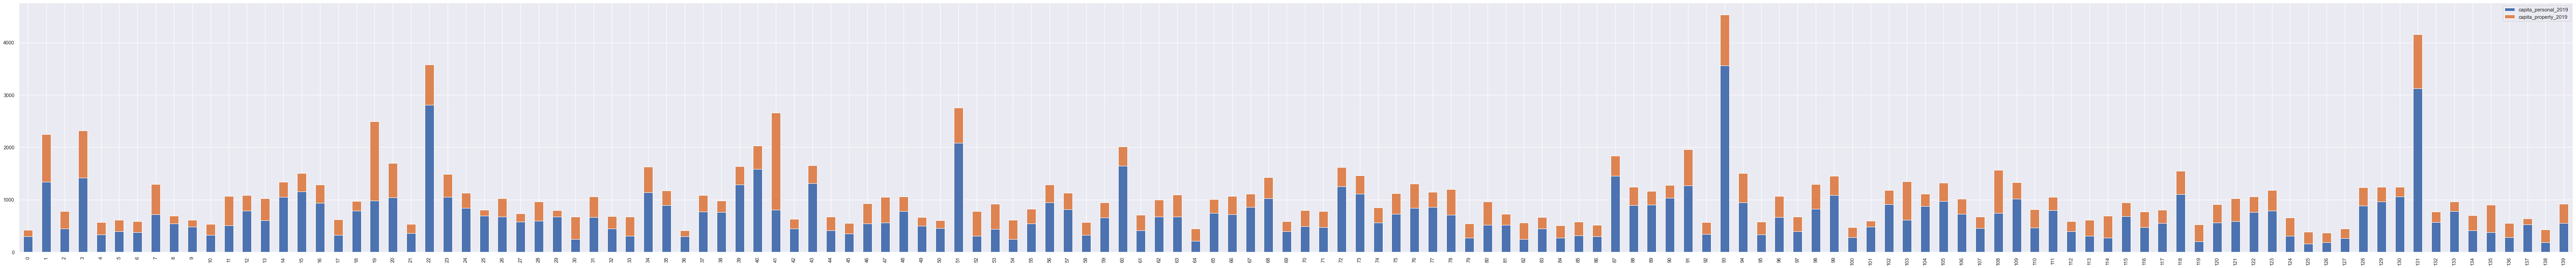

In [261]:
df_tps_hood_graph[['Neighbourhood','capita_personal_2019','capita_property_2019']].plot.bar(stacked=True, figsize=(100,10))

# could do better graphs...


In [248]:
df_tps_hood.describe()
# mean of personal crimes per capita is 717 (per 100K) and property crimes is 358 (per 100K)

,OBJECTID,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_AVG,...,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length,personal_2019,property_2019,capita_personal_2019,capita_property_2019
count,140.0000,140.0000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,...,140.000000,140.000000,140.000000,140.000000,1.400000e+02,140.000000,140.000000,140.000000,140.000000,140.000000
mean,70.5000,70.5000,19511.221429,117.350000,126.885714,132.200000,134.607143,138.935714,145.900000,132.646429,...,9.678571,8.082857,0.377643,47.132143,4.589400e+06,10138.063215,146.457143,71.685714,717.332823,358.498602
std,40.5586,40.5586,10033.589222,106.968961,119.613531,126.501014,137.168053,142.883824,148.500529,128.977375,...,11.918348,9.427947,0.925275,41.478434,4.665326e+06,5545.517459,148.871263,69.724131,499.784286,233.774959
min,1.0000,1.0000,6577.000000,16.000000,12.000000,10.000000,20.000000,15.000000,17.000000,18.500000,...,0.000000,1.200000,-1.000000,0.000000,4.241968e+05,2574.408515,17.000000,12.000000,161.076369,109.424155
25%,35.7500,35.7500,12019.500000,53.750000,57.250000,57.500000,58.750000,58.750000,62.000000,59.425000,...,3.000000,3.500000,-0.200000,22.750000,1.861853e+06,6372.358386,63.500000,35.750000,396.395437,237.814325
50%,70.5000,70.5000,16749.500000,85.000000,92.000000,97.000000,94.000000,93.500000,99.500000,96.500000,...,6.000000,5.200000,0.110000,37.400000,3.290879e+06,8962.102935,100.000000,49.500000,605.703005,299.571011
75%,105.2500,105.2500,23854.500000,141.250000,152.250000,166.250000,159.500000,167.500000,172.000000,160.200000,...,10.250000,8.350000,0.670000,54.650000,5.402335e+06,11899.512705,172.000000,81.500000,882.863069,394.830646
max,140.0000,140.0000,65913.000000,738.000000,826.000000,888.000000,905.000000,910.000000,916.000000,851.800000,...,73.000000,56.200000,4.000000,283.000000,3.753449e+07,43080.724701,919.000000,617.000000,3562.429740,1852.185399


In [266]:
# how many CRCs at each neighbourhood?

crc = df_mapping[['Location Name','Hood_ID']].groupby('Hood_ID').count().reset_index()
crc.columns = ['Hood_ID','CRCs']
df_tps_hood = pd.merge(df_tps_hood,crc, how="left",on=["Hood_ID"])
df_tps_hood = df_tps_hood.fillna(0)
df_tps_hood

,OBJECTID,Neighbourhood,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,...,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length,personal_2019,property_2019,capita_personal_2019,capita_property_2019,Location Name,CRCs
0,1,Yonge-St.Clair,97,12528,20,29,39,27,34,37,...,1.00,47.9,1.161315e+06,5873.270582,37,16,295.338442,127.713921,0.0,0.0
1,2,York University Heights,27,27593,271,296,361,344,357,370,...,-0.26,101.5,1.324666e+07,18504.777326,370,251,1340.919798,909.650998,2.0,2.0
2,3,Lansing-Westgate,38,16164,44,80,68,85,75,72,...,0.83,68.1,5.346186e+06,11112.109625,72,54,445.434298,334.075724,2.0,2.0
3,4,Yorkdale-Glen Park,31,14804,106,136,174,161,175,209,...,0.45,195.9,6.038326e+06,10079.426920,210,133,1418.535531,898.405836,1.0,1.0
4,5,Stonegate-Queensway,16,25051,88,71,76,95,87,82,...,-0.43,16.0,7.946202e+06,11853.189878,82,60,327.332242,239.511397,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,136,Milliken,130,26572,66,92,88,80,78,99,...,0.22,82.8,9.477859e+06,16781.477343,100,139,376.335993,523.107030,1.0,1.0
136,137,Pleasant View,46,15818,34,50,58,53,37,44,...,-0.20,25.3,2.967493e+06,7944.829848,44,43,278.164117,271.842205,1.0,1.0
137,138,Wychwood,94,14349,54,76,86,55,76,74,...,-1.00,0.0,1.682111e+06,5435.021879,75,17,522.684508,118.475155,0.0,0.0
138,139,Leaside-Bennington,56,16828,38,27,33,35,33,31,...,0.75,41.6,4.784766e+06,14836.618578,31,41,184.216782,243.641550,2.0,2.0


In [280]:
df_tps_hood.describe()

# mean of CRCs is 1.18
# we will not impute for CRCs nor remove those records, instead will be zero 

,OBJECTID,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_AVG,...,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length,personal_2019,property_2019,capita_personal_2019,capita_property_2019,Location Name,CRCs
count,140.0000,140.0000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,...,140.000000,140.000000,1.400000e+02,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,70.5000,70.5000,19511.221429,117.350000,126.885714,132.200000,134.607143,138.935714,145.900000,132.646429,...,0.377643,47.132143,4.589400e+06,10138.063215,146.457143,71.685714,717.332823,358.498602,1.185714,1.185714
std,40.5586,40.5586,10033.589222,106.968961,119.613531,126.501014,137.168053,142.883824,148.500529,128.977375,...,0.925275,41.478434,4.665326e+06,5545.517459,148.871263,69.724131,499.784286,233.774959,1.042863,1.042863
min,1.0000,1.0000,6577.000000,16.000000,12.000000,10.000000,20.000000,15.000000,17.000000,18.500000,...,-1.000000,0.000000,4.241968e+05,2574.408515,17.000000,12.000000,161.076369,109.424155,0.000000,0.000000
25%,35.7500,35.7500,12019.500000,53.750000,57.250000,57.500000,58.750000,58.750000,62.000000,59.425000,...,-0.200000,22.750000,1.861853e+06,6372.358386,63.500000,35.750000,396.395437,237.814325,0.000000,0.000000
50%,70.5000,70.5000,16749.500000,85.000000,92.000000,97.000000,94.000000,93.500000,99.500000,96.500000,...,0.110000,37.400000,3.290879e+06,8962.102935,100.000000,49.500000,605.703005,299.571011,1.000000,1.000000
75%,105.2500,105.2500,23854.500000,141.250000,152.250000,166.250000,159.500000,167.500000,172.000000,160.200000,...,0.670000,54.650000,5.402335e+06,11899.512705,172.000000,81.500000,882.863069,394.830646,2.000000,2.000000
max,140.0000,140.0000,65913.000000,738.000000,826.000000,888.000000,905.000000,910.000000,916.000000,851.800000,...,4.000000,283.000000,3.753449e+07,43080.724701,919.000000,617.000000,3562.429740,1852.185399,5.000000,5.000000


In [282]:
%%html
<iframe src="https://learngis3.maps.arcgis.com/apps/mapviewer/index.html?webmap=d1a457ad90cf424084fe5dc9da9457a5" width="1200" height="1000"></iframe>

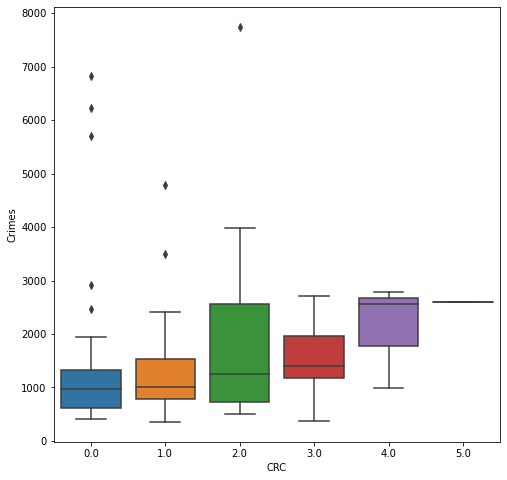

In [108]:
# Looking at CRC (did this with the original TPS data before learning of the other set)
# per hood ID, number of crimes vs number of rec centres
# ignoring the outliers, is this showing no benefit having more rec centres?

crc = df_mapping[['Location Name','Hood_ID']].groupby('Hood_ID').count().reset_index()
crime_hood = df_tps[['Hood_ID','event_unique_id']].groupby('Hood_ID').count().reset_index()

crime_crc = pd.merge(crime_hood,crc, how="left",on=["Hood_ID"])
crime_crc = crime_crc.fillna(0)
crime_crc.columns=['Hood_ID','Crimes','CRC']

plt.figure(figsize=(8,8))
sns.boxplot(x="CRC", y="Crimes", data=crime_crc)

In [111]:
# lets now categorize severity of crimes and re-plot the relationship vs numbre of rec centres

crime_category = df_tps[['MCI','event_unique_id']].groupby('MCI').count().reset_index()
crime_category.columns = ['category', 'Number of crimes']
crime_category

,category,Number of crimes
0,Assault,111423
1,Auto Theft,23380
2,Break and Enter,43302
3,Robbery,21543
4,Theft Over,6787


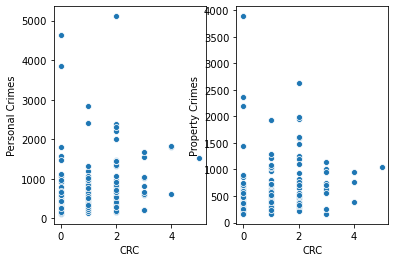

In [137]:
# align the scale of Y avis or better yet plot both on one graph with 2 different colors

# lets now categorize severity of crimes and re-plot the relationship vs number of rec centres
# categorize ASSAULT as PERSONAL CRIME and everything else as PROPERTY CRIME

df_personalcrime = df_tps[df_tps['MCI']=="Assault"]
personalcrime_hood = df_personalcrime[['Hood_ID','event_unique_id']].groupby('Hood_ID').count().reset_index()
personalcrime_crc = pd.merge(personalcrime_hood,crc, how="left",on=["Hood_ID"])
personalcrime_crc = personalcrime_crc.fillna(0)
personalcrime_crc.columns=['Hood_ID','Personal Crimes','CRC']

df_propertycrime = df_tps[df_tps['MCI']!="Assault"]
propertycrime_hood = df_propertycrime[['Hood_ID','event_unique_id']].groupby('Hood_ID').count().reset_index()
propertycrime_crc = pd.merge(propertycrime_hood,crc, how="left",on=["Hood_ID"])
propertycrime_crc = propertycrime_crc.fillna(0)
propertycrime_crc.columns=['Hood_ID','Property Crimes','CRC']

#plt.figure(figsize=(20,20))
fig,ax = plt.subplots(1,2)
sns.scatterplot(x="CRC", y="Personal Crimes", data=personalcrime_crc, ax=ax[0])
sns.scatterplot(x="CRC", y="Property Crimes", data=propertycrime_crc, ax=ax[1])
#fig.show()

In [132]:
propertycrime_crc

,Hood_ID,Property Crimes,CRC
0,1,3891,0.0
1,2,1056,5.0
2,3,370,2.0
3,4,398,1.0
4,5,266,2.0
...,...,...,...
135,136,1085,1.0
136,137,1490,2.0
137,138,739,0.0
138,139,517,1.0


In [86]:
from arcgis.gis import GIS
from arcgis.geocoding import geocode
from IPython.display import display

gis = GIS()
map1 = gis.map()
map1

MapView(layout=Layout(height='400px', width='100%'))

In [41]:
# set the map's extent by geocoding the location
toronto = geocode("Toronto")[0]
map1.extent = toronto['extent']

In [45]:
df_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Location ID         1941 non-null   int64 
 1   Parent Location ID  1941 non-null   int64 
 2   Location Name       1940 non-null   object
 3   Location Type       1861 non-null   object
 4   Accessibility       138 non-null    object
 5   Intersection        1621 non-null   object
 6   TTC Information     222 non-null    object
 7   District            1933 non-null   object
 8   Street No           1916 non-null   object
 9   Street No Suffix    38 non-null     object
 10  Street Name         1940 non-null   object
 11  Street Type         1881 non-null   object
 12  Street Direction    190 non-null    object
 13  Postal Code         197 non-null    object
 14  Description         985 non-null    object
dtypes: int64(2), object(13)
memory usage: 227.6+ KB


In [61]:
# replace NaNs
df_locations.fillna('',inplace=True)

df_locations['ADDRESS']= df_locations['Street No'] + " " + df_locations['Street Name']
df_locations

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [48]:
crc = df_locations.loc[df_locations['Location Type']=="crc"]

In [49]:
layer_crc = gis.content.import_data(crc)
map1.add_layer(layer_crc)

In [9]:
df_tps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206435 entries, 0 to 206434
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   X                    206435 non-null  float64
 1   Y                    206435 non-null  float64
 2   Index_               206435 non-null  int64  
 3   event_unique_id      206435 non-null  object 
 4   occurrencedate       206435 non-null  object 
 5   reporteddate         206435 non-null  object 
 6   premisetype          206435 non-null  object 
 7   ucr_code             206435 non-null  int64  
 8   ucr_ext              206435 non-null  int64  
 9   offence              206435 non-null  object 
 10  reportedyear         206435 non-null  int64  
 11  reportedmonth        206435 non-null  object 
 12  reportedday          206435 non-null  int64  
 13  reporteddayofyear    206435 non-null  int64  
 14  reporteddayofweek    206435 non-null  object 
 15  reportedhour     

In [ ]:
#import the data
df_crime = pd.read_csv(r'C:\Users\Student\OneDrive - York University\Big Data Analytics course\Project\MCI_2014_to_2019.csv')
df_crime.head()

In [ ]:
#understand the data
df_crime.info()

In [ ]:
#describe the data
df_crime.describe()

In [ ]:
#check for the null values
df_crime.isnull().sum()

In [ ]:
#groupby crime category
crime_category = df_crime[['MCI','event_unique_id']].groupby('MCI').count().reset_index()


In [ ]:
crime_category.columns = ['category', 'Number of crimes']

In [ ]:
crime_category

In [ ]:
#plot the data 
plt.figure(figsize = (15,6))
sns.barplot(x = crime_category['category'], y = 'Number of crimes', data = crime_category, color = 'red')
plt.xticks(rotation = 90)
plt.xlabel("")
plt.title('Categories of Crime', fontdict = {'color': 'darkred', 'size':16})
#plt.text(x = 20, y = 35000,s = "Larceny/Theft : 26% \nNon-Criminal  : 11%", fontsize = 16, color = 'blue')
plt.show()

In [ ]:
#groupby the data with the day of the week
crime_day = df_crime[['occurrencedayofweek','event_unique_id']].groupby('occurrencedayofweek').count().reset_index()
crime_day

In [ ]:
crime_day['percentage'] = (crime_day['event_unique_id']/crime_day['event_unique_id'].sum())*100
crime_day

In [ ]:
#plot the data
plt.figure(figsize = (7,7))
plt.pie(x = crime_day['percentage'], labels = crime_day['occurrencedayofweek'], explode = [0.1,0,0,0,0,0,0], shadow = True, autopct = '%1.1f%%')
plt.show()

In [ ]:
#grouby the data for different neighbourhood of the toronto
crime_neighbour = df_crime[['Neighbourhood','event_unique_id']].groupby('Neighbourhood').count().reset_index()
crime_neighbour

In [ ]:
crime_neighbour.loc[:,'Neighbourhood'] = crime_neighbour.loc[:,'Neighbourhood'].str.replace('\(\d+\)','')
crime_neighbour

In [ ]:
#plot the data for the different neighbourhoods of Toronto
plt.figure(figsize = [10,20])
sns.barplot(x = 'event_unique_id',y = crime_neighbour['Neighbourhood'], data = crime_neighbour, palette = ['red']+['grey']*8+['blue'])
plt.xlabel('')
plt.ylabel('Count')
plt.title('Neighbour Wise counts of crime', fontdict = {'color': 'darkred', 'size':16})
plt.show()

In [ ]:
crime_type = df_crime[['offence','event_unique_id']].groupby('offence').count().reset_index()
crime_type.head()

In [ ]:
#groupby the data with the years
crime_year = df_crime[['occurrenceyear','event_unique_id']].groupby('occurrenceyear').count().reset_index()
crime_year.head()

In [ ]:
#Plot the data
plt.figure(figsize = [10,7])
sns.barplot(x = crime_year['occurrenceyear'],y ='event_unique_id' , data = crime_neighbour)
plt.xlabel('')
plt.ylabel('Count')
plt.title('occurrenceyear', fontdict = {'color': 'darkred', 'size':16})
plt.xticks(rotation = 90)
plt.show()

In [ ]:
#calculate the crime rate for the month
crime_month = df_crime[['occurrencemonth','event_unique_id']].groupby('occurrencemonth').count().reset_index()
crime_month.head()

In [ ]:
#plot the data
plt.figure(figsize = (10,7))
sns.barplot(x = crime_month['occurrencemonth'], y = 'event_unique_id', data = crime_month, color = 'red')
plt.title('Months vs Crimes', fontdict = {'color': 'darkred', 'size':16})

In [ ]:
#generate a feature to calculate crime for the part of a day
def PartofDay(a):
    if a in [23,0,1,2]:
        return 'Midnight'
    elif a in [3,4,5,6]:
        return 'Early Morning'
    elif a in [7,8,9,10]:
        return 'Morning'
    elif a in [11,12,13,14]:
        return 'Noon'
    elif a in [15,16,17,18]:
        return 'Evening'
    else:
        return 'Night'



In [ ]:
df_crime['PartofDay'] = df_crime.occurrencehour.apply(PartofDay)

In [ ]:
crime_PartofDay = df_crime[['PartofDay','event_unique_id']].groupby('PartofDay').count().reset_index()
crime_PartofDay

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = crime_PartofDay['PartofDay'], y = 'event_unique_id', data = crime_PartofDay, color = 'red')
plt.title('Part of the Day vs Crimes', fontdict = {'color': 'darkred', 'size':16})

In [ ]:
#heatmap for month and day of the month
crime_day_month = pd.pivot_table(columns = df_crime.occurrenceday,values = 'occurrenceday' ,index = 'occurrencemonth',
                                 aggfunc = 'count', data = df_crime)
plt.figure(figsize = (12,6))
sns.heatmap(crime_day_month, cmap = 'Reds')
plt.yticks(np.arange(0.5,12.5) ,['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
df_crime[(df_crime.occurrencemonth=='June') & (df_crime.occurrenceday == 4)].groupby('occurrenceyear').count()

In [ ]:
df_crime.occurrencedayofweek

In [ ]:
#heatmap for day and part of the day
crime_day_week = pd.pivot_table(columns = df_crime['PartofDay'] ,index = 'occurrencedayofweek',
                                values = 'PartofDay' , aggfunc = 'count', data = df_crime)
#crime_day_week = crime_day_week.reindex(index = ['Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday'],
#                                        columns = ['Early Morning','Evening','Midnight','Morning','Night','Noon'])
plt.figure(figsize = (15,6))
sns.heatmap(crime_day_week, cmap = 'Reds',annot = True,fmt = 'd')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
crime_day_week = pd.pivot_table(columns = df_crime['PartofDay'] ,index = 'occurrencedayofweek',
                                values = 'PartofDay' , aggfunc = 'count', data = df_crime)
crime_day_week

In [ ]:
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder

In [ ]:
df_crime.dropna(inplace=True)

In [ ]:
#df_crime['occurrenceday', 'occurrencehour', 'Long', 'Lat']
X = pd.DataFrame()
le = LabelEncoder()
df_crime['target'] = le.fit_transform(df_crime["MCI"])
#crime_category[crime_category.category]

In [ ]:
#feature engineering
df_crime['occurrencedate']=pd.to_datetime(df_crime['occurrencedate'])

In [ ]:
def feature_engineering(data):
    data['Date'] = pd.to_datetime(pd.to_datetime(data['occurrencedate']).dt.date)
    data['n_days'] = (
        data['Date'] - data['Date'].min()).apply(lambda x: x.days)
    data['Day'] = data['occurrencedate'].dt.day
    data['DayOfWeek'] = data['occurrencedate'].dt.weekday
    data['Month'] = data['occurrencedate'].dt.month
    data['Year'] = data['occurrencedate'].dt.year
    data['Hour'] = data['occurrencehour']

        
    return data

In [ ]:
feature_engineering(df_crime)

In [ ]:
model_columns = ['Neighbourhood','Long', 'Lat','n_days', 'Day', 'DayOfWeek', 'Month', 'Year', 'Hour','target']

In [ ]:
model_data = df_crime[model_columns]

In [ ]:
model_data.head()

In [ ]:
le1 = LabelEncoder()
model_data['Neighbourhood'] = le1.fit_transform(model_data['Neighbourhood'])

In [ ]:
model_data

In [ ]:
#split the data into train test sets
train_X, test_X, train_y, test_y = train_test_split(model_data[['Neighbourhood','Long', 'Lat','n_days',
                                                                'Day', 'DayOfWeek', 'Month', 'Year', 'Hour']],model_data['target'])

In [ ]:
model =LGBMClassifier(objective='multiclass', num_class=5).fit(train_X, train_y)

perm = PermutationImportance(model).fit(test_X, test_y)
eli5.show_weights(perm, feature_names=test_X.columns.tolist())

In [ ]:
train_data = lgb.Dataset(train_X, label=train_y, categorical_feature=['Neighbourhood'])

In [ ]:
params = {'boosting':'gbdt',
          'objective':'multiclass',
          'num_class':5,
          'max_delta_step':0.9,
          'min_data_in_leaf': 21,
          'learning_rate': 0.4,
          'max_bin': 465,
          'num_leaves': 41
         }

In [ ]:
bst = lgb.train(params, train_data, 100)

predictions = bst.predict(test_X)

In [ ]:
predictions.shape

In [ ]:
submission = pd.DataFrame(predictions, columns=le.inverse_transform(np.linspace(0, 4, 5, dtype='int16')),index=test_y.index)

In [ ]:
submission.head()


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)

In [ ]:
knn.fit(train_X,train_y)

In [ ]:
knn.score(test_X,test_y)

In [ ]:
label_dict = dict(zip(df_crime.target.unique(), df_crime.MCI.unique()))
label_dict

In [ ]:
pred_2019 = model_data[model_data.Year==2019].drop('target', axis = 1)

In [ ]:
knn_prediction = knn.predict(pred_2019)

In [ ]:
label_dict[knn_prediction[0]]

In [ ]:
knn_prediction

In [ ]:
reg = LogisticRegression(C=100).fit(train_X,train_y)

In [ ]:
reg.score(test_X,test_y)

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(kernel='linear', C=1).fit(train_X,train_y)

In [ ]:
svc.score(test_X, test_y)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
Lreg = LinearRegression().fit(train_X,train_y)

In [ ]:
Lreg.score(test_X, test_y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
Dclf = DecisionTreeClassifier().fit(train_X,train_y)

In [ ]:
Dclf.score(test_X, test_y)

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
nbclf = GaussianNB().fit(train_X,train_y)

In [ ]:
nbclf.score(test_X, test_y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rclf = RandomForestClassifier().fit(train_X,train_y)

In [ ]:
rclf.score(test_X, test_y)

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
nnclf = MLPClassifier(hidden_layer_sizes=3, solver='lbfgs').fit(train_X,train_y)

In [ ]:
nnclf.score(test_X, test_y)

In [ ]:
pred_rf = rclf.predict(pred_2019)

In [ ]:
ser_rf = pd.Series(pred_rf)

In [ ]:
ser_rf.map(label_dict)

In [ ]:
plt.scatter(x.index,x, label= 'Actual')
plt.scatter(y.index,y, label= 'Predicted')
plt.ylabel('crime count')
plt.title('Crime rate in 2019')
plt.legend()
plt.xticks([])

In [ ]:
x = (model_data[model_data.Year==2019]).target.value_counts()

In [ ]:
y = ser_rf.value_counts()

In [ ]:
x

In [ ]:
label_dict

In [ ]:
['Assault','Auto Theft','Break and Enter','Robbery','Theft Over']